In [20]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from jupyterthemes import jtplot
import os
#jtplot.style(theme='solarizedl')

In [21]:
def Euler(f: Callable, X0: np.array, t: np.array):
    h = (t[-1] + t[0]) / len(t)
    X = np.zeros((len(t), len(X0)))
    X[0] = X0
    for i in range(len(t) - 1):
        X[i + 1] = X[i] + h * f(X[i], t[i])
    return X

def Trapezoidal(f: Callable, X0: np.array, t: np.array):
    h = (t[-1] + t[0]) / len(t)
    X = np.zeros((len(t), len(X0)))
    X[0] = X0
    for i in range(len(t) - 1):
        k1 = f(X[i], t[i])
        k2 = f(X[i] + h * k1, t[i] + h)
        X[i + 1] = X[i] + (h / 2) * (k1 + k2)
    return X

def Midpoint(f: Callable, X0: np.array, t: np.array):
    h = (t[-1] + t[0]) / len(t)
    X = np.zeros((len(t), len(X0)))
    X[0] = X0
    for i in range(len(t) - 1):
        k = f(X[i] + (h / 2) * f(X[i], t[i]), t[i] + (h / 2))
        X[i + 1] = X[i] + h * k
    return X

def RK4(f: Callable, X0: np.array, t: np.array):
    h = (t[-1] + t[0]) / len(t)
    X = np.zeros((len(t), len(X0)))
    X[0] = X0
    for i in range(len(t) - 1):
        k1 = f(X[i], t[i])
        k2 = f(X[i] + (h / 2) * k1, t[i] + h / 2)
        k3 = f(X[i] + (h / 2) * k2, t[i] + h / 2)
        k4 = f(X[i] + h * k3, t[i] + h)
        X[i + 1] = X[i] + (h / 6) * (k1 + (2 * k2) + (2 * k3) + k4)
    return X

In [34]:
class LotkaVolterra:
    def __init__(self, parameters: dict):
        self.a = parameters['a'] # natural growth rate of prey
        self.b = parameters['b'] # natural dying rate of prey due to predation
        self.c = parameters['c'] # natural dying rate of predator
        self.d = parameters['d'] # caught prey per new predator
        self.paths = {}
        self.paths["figures"]    = os.path.join(os.getcwd(), "figures")
        self.paths["phase"]      = os.path.join(self.paths["figures"], "phase")
        self.paths["population"] = os.path.join(self.paths["figures"], "population")
        
    
    def dx_dt(self, X: np.array, t: float = 0) -> np.array:
        """ 
        Returns the growth rate of fox and rabbit populations. 

        """
        return np.array( [self.a * X[0] - (self.b * X[0] * X[1]),
                         -self.c * X[1] + (self.d * self.b * X[0] * X[1])] )
    
    def jacobian(self, X: np.array, t: float = 0) -> np.array:
        """
        Returns the Jacobian matrix evaluated in X
        
        """
        return np.array([ [self.a - self.b * X[1], -self.b * X[0]],
                          [self.d * self.b * X[1], -self.c + self.d * self.b * X[0]] ])

    def fixed_points(self) -> List[np.array]:
        X_f0 = np.array([ 0.0, 0.0 ])
        X_f1 = np.array([ self.c / (self.d * self.b), self.a / self.b])
        return self.jacobian(X_f0), self.jacobian(X_f1)
    
    def phase(self, ode: Callable, values: np.array, colors: np.array, title: str, savefig: bool = False, name: str = "phase.png"):
        X_f0 = np.array([0.0, 0.0])
        X_f1 = np.array([ self.c / (self.d * self.b), self.a / self.b])
        
        fig = plt.figure(figsize=(8,6))
        #points = []
        for v, color in zip(values, colors):
            X0 = v * X_f1
            #points.append([X0])
            X = ode(self.dx_dt, X0, t)
            plt.plot( X[:, 0], X[:, 1], lw = (1), color = color, label = f"X0 = ({X0[0]}, {X0[1]})" )
            plt.scatter(X0[0], X0[1], color = color)
        plt.title(title)
        plt.xlabel("Prey")
        plt.ylabel("Predator")
        plt.grid(False)
        if savefig: 
            plt.savefig(os.path.join(self.paths["phase"], name), dpi=250)
        plt.show()
        
    def solve(self, ode: Callable, X0: np.array, t: np.array):
        return ode(self.dx_dt, X0, t)
        
        #self.plot_results(X, t)
        #return integrate.odeint(dx_dt, X0, t, full_output = True)
        
    def plot_results(self, 
                     X: np.array, 
                     t: np.array, 
                     prey_label: str = "Prey", 
                     pred_label: str = "Predator", 
                     title:      str = "Populations Over Time",
                     filename:   str = "tmp.jpg"):
        
        prey, predator = X.T
        fig = plt.figure(figsize=(6,6))
        plt.plot(t, prey, color = 'olive', label = prey_label)
        plt.plot(t, predator, color = 'firebrick', label = pred_label)
        plt.grid(False)
        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Population Size")
        plt.title(title)
        plt.savefig(os.path.join(self.paths["population"], filename))
        plt.show()
        
        

In [23]:
# define parameters and instantiate model
parameters = {
    'a': 2 / 3,
    'b': 4 / 3,
    'c': 1.2,
    'd': 0.8
}

model = LotkaVolterra(parameters)

methods = [Euler, Midpoint, Trapezoidal, RK4] #, integrate.odeint]
labels  = ["Explicit Euler", "Explicit Midpoint", "Explicit Trapezoidal", "RK4"] # , "Isolda"]

<ipython-input-22-148620f5978a>:18: RuntimeWarning: overflow encountered in double_scalars
  return np.array( [self.a * X[0] - (self.b * X[0] * X[1]),
<ipython-input-22-148620f5978a>:19: RuntimeWarning: overflow encountered in double_scalars
  -self.c * X[1] + (self.d * self.b * X[0] * X[1])] )
<ipython-input-22-148620f5978a>:19: RuntimeWarning: invalid value encountered in double_scalars
  -self.c * X[1] + (self.d * self.b * X[0] * X[1])] )


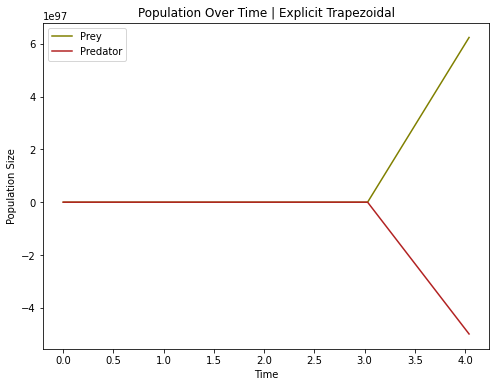

In [24]:
h = 1
T = 100
t  = np.linspace(0, T, int(T / h))
ode = integrate.odeint
X0 = np.array([3, 3])

i = 2

X = model.solve(methods[i], X0, t)
name = labels[i] + "_" + str(h) + "_" + str(T) + ".jpg"
model.plot_results(X, t, title = "Population Over Time | " + labels[i], filename = name)

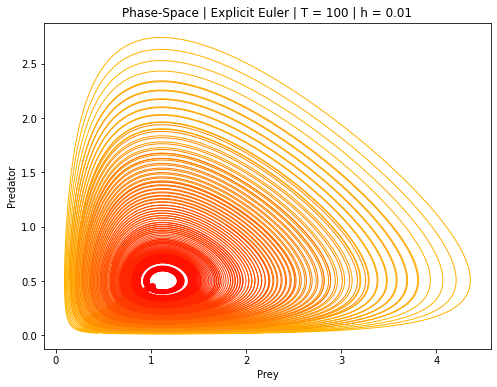

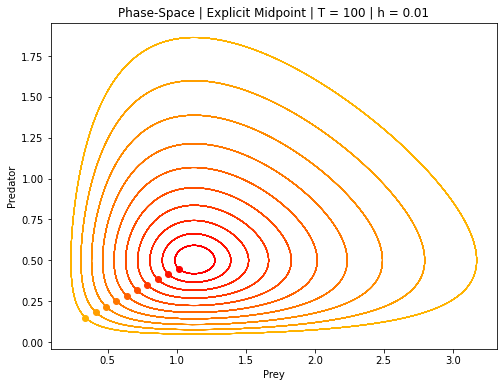

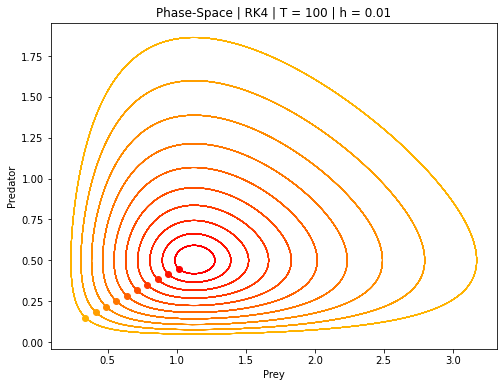

In [31]:
parameters = {
    'a': 2 / 3,
    'b': 4 / 3,
    'c': 1.2,
    'd': 0.8
}

model = LotkaVolterra(parameters)
methods = [Euler, Midpoint, RK4] 
labels  = ["Explicit Euler", "Explicit Midpoint", "RK4"] 

h = .01
T = 100
t  = np.linspace(0, T, int(T / h))
X0 = np.array([3, 3])
values = np.linspace(0.3, 0.9, 10)
vcolors = plt.cm.autumn_r(np.linspace(0.3, 1., len(values)))

for method, label in zip(methods, labels):
    title = f"Phase-Space | {label} | T = {T} | h = {h}"
    model.phase(method, values, vcolors, title, savefig = True, name = label + '_' + str(h) + '_' + str(T) + '.jpg')
    
    
    
#     X = model.solve(method, X0, t)
#     name = label + "_" + str(h) + "_" + str(T) + ".jpg"
#     title = f"Population Over Time | {label} | T = {T} | h = {h}"
#     model.plot_results(X, t, title = title, filename = name)

# title = f"Phase-Space | {labels[i]} | T = {T} | h = {h}"
# model.phase(methods[i], values, vcolors, title, savefig = True, name = labels[i] + '_' + str(h) + '_' + str(T) + '.jpg')

<ipython-input-34-7de279312e89>:18: RuntimeWarning: overflow encountered in double_scalars
  return np.array( [self.a * X[0] - (self.b * X[0] * X[1]),
<ipython-input-34-7de279312e89>:19: RuntimeWarning: overflow encountered in double_scalars
  -self.c * X[1] + (self.d * self.b * X[0] * X[1])] )
<ipython-input-34-7de279312e89>:19: RuntimeWarning: invalid value encountered in double_scalars
  -self.c * X[1] + (self.d * self.b * X[0] * X[1])] )


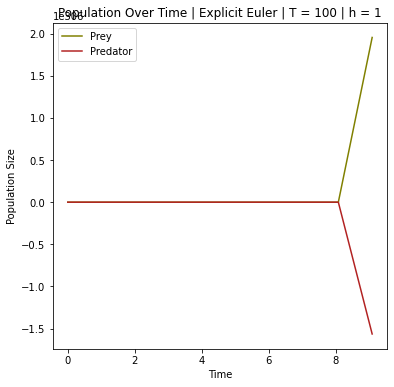

<ipython-input-34-7de279312e89>:18: RuntimeWarning: overflow encountered in double_scalars
  return np.array( [self.a * X[0] - (self.b * X[0] * X[1]),
<ipython-input-34-7de279312e89>:19: RuntimeWarning: overflow encountered in double_scalars
  -self.c * X[1] + (self.d * self.b * X[0] * X[1])] )
<ipython-input-34-7de279312e89>:19: RuntimeWarning: invalid value encountered in double_scalars
  -self.c * X[1] + (self.d * self.b * X[0] * X[1])] )


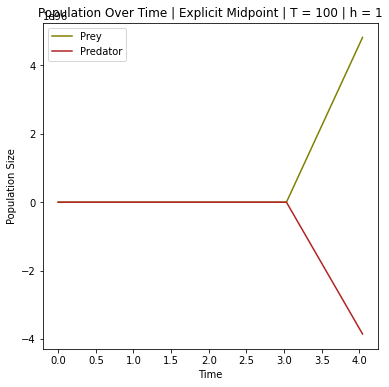

<ipython-input-34-7de279312e89>:18: RuntimeWarning: overflow encountered in double_scalars
  return np.array( [self.a * X[0] - (self.b * X[0] * X[1]),
<ipython-input-34-7de279312e89>:19: RuntimeWarning: overflow encountered in double_scalars
  -self.c * X[1] + (self.d * self.b * X[0] * X[1])] )
<ipython-input-34-7de279312e89>:19: RuntimeWarning: invalid value encountered in double_scalars
  -self.c * X[1] + (self.d * self.b * X[0] * X[1])] )


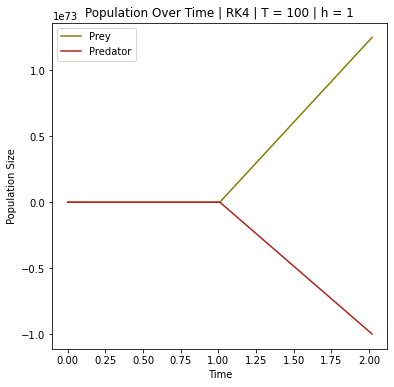

In [37]:
parameters = {
    'a': 2 / 3,
    'b': 4 / 3,
    'c': 1.2,
    'd': 0.8
}

model = LotkaVolterra(parameters)
methods = [Euler, Midpoint, RK4] 
labels  = ["Explicit Euler", "Explicit Midpoint", "RK4"] 

h = 1
T = 100
t  = np.linspace(0, T, int(T / h))
X0 = np.array([5, 3])

for method, label in zip(methods, labels):
    X = model.solve(method, X0, t)
    name = label + "_" + str(h) + "_" + str(T) + ".jpg"
    title = f"Population Over Time | {label} | T = {T} | h = {h}"
    model.plot_results(X, t, title = title, filename = name)